# 📈 Backtesting: Historical Data Validation

This notebook demonstrates backtesting trained RL agents on real historical market data.

**Topics covered:**
- Loading historical options data
- Walk-forward validation
- Realistic execution simulation
- Performance attribution
- Comparison with baselines

**Time required:** ~30-40 minutes

## 1. Setup

In [5]:
# Add project root to Python path
import sys
from pathlib import Path

# Get the project root (parent of notebooks directory)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✓ Project root: {project_root}")
print(f"✓ Python path configured")

✓ Project root: e:\Derivative_Hedging_RL
✓ Python path configured


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from src.environments.hedging_env import OptionHedgingEnv
from src.environments.real_data_env import create_real_data_env
from src.data.historical_loader import HistoricalDataLoader
from src.agents.ppo_agent import PPOHedgingAgent
from src.agents.config import ENV_CONFIGS
from src.baselines.hedging_strategies import DeltaHedging, DeltaGammaHedging
from src.pricing.black_scholes import BlackScholesModel

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Setup complete!")

✓ Setup complete!


## 2. Load Historical Data

We'll use the SPY options and underlying data that was downloaded earlier.

In [7]:
# Load PROCESSED historical market data
print("Loading processed market data...")

# Use absolute path from project root
data_dir = project_root / "data" / "processed"
loader = HistoricalDataLoader(data_dir=str(data_dir))

market_data = loader.load_market_data()

print(f"\n✓ Market Data Loaded: {len(market_data)} rows")
print(f"Date range: {market_data['Date'].min()} to {market_data['Date'].max()}")
print(f"\nColumns available: {list(market_data.columns)}")
print(f"\nFirst few rows:")
print(market_data.head())
print(f"\n💡 This data includes SPY prices, VIX, risk-free rates, and technical indicators")

Loading processed market data...
✓ Loaded market data: 2716 rows

✓ Market Data Loaded: 2716 rows
Date range: 2015-03-16 00:00:00 to 2025-12-30 00:00:00

Columns available: ['Date', 'SPY_Close', 'SPY_High', 'SPY_Low', 'SPY_Open', 'SPY_Volume', 'SPY_returns', 'SPY_log_returns', 'SPY_sma_20', 'SPY_sma_50', 'SPY_ema_20', 'SPY_volatility_20', 'SPY_volume_sma_20', 'SPY_returns_std_20', 'SPY_returns_mean_20', 'SPY_momentum_5', 'SPY_momentum_10', 'SPY_momentum_20', 'SPY_hl_range', 'VIX', 'risk_free_rate', 'AAPL_Close', 'AAPL_returns', 'AAPL_volatility_20', 'QQQ_Close', 'QQQ_returns', 'QQQ_volatility_20', 'IWM_Close', 'IWM_returns', 'IWM_volatility_20', 'GLD_Close', 'GLD_returns', 'GLD_volatility_20']

First few rows:
        Date   SPY_Close    SPY_High     SPY_Low    SPY_Open  SPY_Volume  \
0 2015-03-16  173.205383  173.296728  170.946687  171.652534   136099200   
1 2015-03-17  172.690552  173.072530  171.876748  172.466339    94510400   
2 2015-03-18  174.766586  175.439211  171.577830  17

## 3. Load Options Chain Data

SPY options data provides real strike prices and implied volatilities.

In [8]:
# Load PROCESSED options chain data
print("Loading processed options data...")
options_data = loader.load_options_data()

print(f"\n✓ Options Data Loaded: {len(options_data)} contracts")
print(f"\nColumns available: {list(options_data.columns)}")
print(f"\nFirst few rows:")
print(options_data.head())

# Show available strikes
if 'strike' in options_data.columns:
    print(f"\nStrike range: ${options_data['strike'].min():.2f} - ${options_data['strike'].max():.2f}")
    print(f"Number of unique strikes: {options_data['strike'].nunique()}")
    print(f"Option types: {options_data['option_type'].unique()}")

Loading processed options data...
✓ Loaded options data: 969 contracts

✓ Options Data Loaded: 969 contracts

Columns available: ['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'expiry', 'option_type', 'spread', 'spread_pct', 'moneyness_simple', 'days_to_expiry', 'time_to_maturity', 'moneyness', 'itm']

First few rows:
       contractSymbol        lastTradeDate  strike  lastPrice     bid     ask  \
0  SPY260220C00335000  2026-02-20 16:42:18   335.0     353.34  353.26  356.01   
1  SPY260220C00345000  2026-02-02 14:42:12   345.0     348.01  343.29  346.01   
2  SPY260220C00350000  2026-02-03 19:25:15   350.0     337.41  338.27  341.01   
3  SPY260220C00365000  2025-11-26 15:41:15   365.0     316.48  327.35  330.81   
4  SPY260220C00370000  2025-11-20 17:07:06   370.0     292.80  322.38  325.77   

     change  percentChange  volume  openInterest  .

## 4. Load Trained Model

We'll use a model trained with curriculum learning.

In [14]:
model_path = Path("models/notebook_backtest/ppo_trained.zip")

if not model_path.exists():
    print("Training model for backtesting...")
    print("(In production, you'd use your best production model)")
    
    from src.agents.trainer import AgentTrainer
    from src.agents.config import get_config
    
    trainer = AgentTrainer(
        agent_type="PPO",
        env_config=ENV_CONFIGS["realistic"],
        output_dir="models/notebook_backtest",
        seed=42
    )
    
    agent = trainer.train_with_curriculum(
        total_timesteps=200000,
        agent_config=get_config("PPO", "default"),
    )
    
    agent.save("models/notebook_backtest/ppo_trained")
    print("✓ Model trained!")
else:
    # Load model with matching environment
    # Model was trained with curriculum learning, final stage is "realistic" config
    env = OptionHedgingEnv(**ENV_CONFIGS["realistic"])
    agent = PPOHedgingAgent.load_pretrained(str(model_path), env=env)
    print("✓ Model loaded!")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✓ Model loaded!


e:\Derivative_Hedging_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
e:\Derivative_Hedging_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
e:\Derivative_Hedging_RL\.venv\Lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


## 5. Prepare Backtesting Data

Create a backtesting dataset with realistic market conditions.

In [15]:
# Prepare backtesting data (already merged and processed!)
backtest_data = market_data.copy()

# Rename columns for backtesting compatibility
backtest_data['implied_vol'] = backtest_data['VIX'] / 100  # VIX to decimal
backtest_data['realized_vol'] = backtest_data['SPY_volatility_20']  # Already calculated

# Remove any NaN rows
backtest_data = backtest_data.dropna(subset=['SPY_Close', 'VIX', 'risk_free_rate']).reset_index(drop=True)

print(f"✓ Prepared backtesting data: {len(backtest_data)} days")
print(f"Date range: {backtest_data['Date'].min()} to {backtest_data['Date'].max()}")
print(f"\nAvailable features:")
print(f"  - SPY prices (Close, Open, High, Low)")
print(f"  - Returns and volatility metrics")
print(f"  - VIX and implied volatility")
print(f"  - Risk-free rates")
print(f"  - Technical indicators (SMA, EMA, momentum)")
print(f"\nSample data:")
print(backtest_data[['Date', 'SPY_Close', 'VIX', 'implied_vol', 'risk_free_rate']].head(10))

✓ Prepared backtesting data: 2716 days
Date range: 2015-03-16 00:00:00 to 2025-12-30 00:00:00

Available features:
  - SPY prices (Close, Open, High, Low)
  - Returns and volatility metrics
  - VIX and implied volatility
  - Risk-free rates
  - Technical indicators (SMA, EMA, momentum)

Sample data:
        Date   SPY_Close    VIX  implied_vol  risk_free_rate
0 2015-03-16  173.205383  15.78       0.1578          0.0210
1 2015-03-17  172.690552  16.31       0.1631          0.0206
2 2015-03-18  174.766586  14.60       0.1460          0.0193
3 2015-03-19  173.969360  14.68       0.1468          0.0198
4 2015-03-20  175.504959  13.52       0.1352          0.0193
5 2015-03-23  175.163010  13.52       0.1352          0.0192
6 2015-03-24  174.178711  13.36       0.1336          0.0188
7 2015-03-25  171.626328  13.26       0.1326          0.0193
8 2015-03-26  171.217636  16.64       0.1664          0.0201
9 2015-03-27  171.609650  15.73       0.1573          0.0195


## 6. Walk-Forward Backtesting Setup

We'll use a rolling window approach:
- Train on past data
- Test on next period
- Roll forward

In [16]:
# Define backtesting parameters
backtest_start_idx = len(backtest_data) // 2  # Start from midpoint
test_window = 60  # Test on 60 days (~ 3 months)
strike_price = 400.0  # Fixed strike for ATM option
risk_free_rate = 0.05  # 5% annual rate

print("Walk-Forward Backtesting Configuration")
print("=" * 80)
print(f"Total data points: {len(backtest_data)}")
print(f"Backtest start: {backtest_data.iloc[backtest_start_idx]['Date']}")
print(f"Test window: {test_window} days")
print(f"Fixed strike: ${strike_price:.2f}")
print(f"Risk-free rate: {risk_free_rate:.1%}")

Walk-Forward Backtesting Configuration
Total data points: 2716
Backtest start: 2020-08-05 00:00:00
Test window: 60 days
Fixed strike: $400.00
Risk-free rate: 5.0%


## 7. Run Backtest: RL Agent

Let's backtest the RL agent on historical data.

In [18]:
def run_backtest_rl(agent, data_df, start_idx, end_idx, strike, r):
    """Run backtest for RL agent."""
    results = []
    current_hedge = 0.0
    total_pnl = 0.0
    total_costs = 0.0
    
    for idx in range(start_idx, min(end_idx, len(data_df))):
        row = data_df.iloc[idx]
        
        # Calculate time to maturity (assume 3-month option, decaying)
        days_elapsed = idx - start_idx
        initial_ttm = 90 / 365  # 3 months
        ttm = max(0.01, initial_ttm - (days_elapsed / 365))
        
        # Market conditions
        spot = row['SPY_Close']
        vol = row['implied_vol']
        
        # Create observation features
        from src.inference.preprocessor import DataPreprocessor
        preprocessor = DataPreprocessor()
        
        features = preprocessor.engineer_features(
            spot_price=spot,
            strike=strike,
            time_to_maturity=ttm,
            risk_free_rate=r,
            volatility=vol,
            option_type='call',
            current_hedge=current_hedge,
        )
        
        # Get action from agent
        action, _ = agent.predict(features, deterministic=True)
        target_hedge = float(action.item() if hasattr(action, 'item') else action[0])
        
        # Calculate hedge adjustment and cost
        hedge_adjustment = target_hedge - current_hedge
        transaction_cost = abs(hedge_adjustment) * spot * 0.001  # 0.1% cost
        
        # Calculate option value change (simplified PnL)
        option_value = BlackScholesModel.price(
            S=spot, K=strike, T=ttm, r=r, sigma=vol, option_type='call'
        )
        
        # PnL from hedge
        if idx > start_idx:
            prev_spot = data_df.iloc[idx-1]['SPY_Close']
            spot_change = spot - prev_spot
            hedge_pnl = current_hedge * spot_change
        else:
            hedge_pnl = 0.0
        
        # Update totals
        episode_pnl = hedge_pnl - transaction_cost
        total_pnl += episode_pnl
        total_costs += transaction_cost
        
        # Record
        results.append({
            'date': row['Date'],
            'spot': spot,
            'volatility': vol,
            'ttm': ttm,
            'target_hedge': target_hedge,
            'hedge_adjustment': hedge_adjustment,
            'transaction_cost': transaction_cost,
            'episode_pnl': episode_pnl,
            'cumulative_pnl': total_pnl,
            'cumulative_costs': total_costs,
        })
        
        # Update current hedge
        current_hedge = target_hedge
    
    return pd.DataFrame(results)

# Run RL backtest
print("Running RL agent backtest...")
print("This may take a few minutes...")

rl_results = run_backtest_rl(
    agent=agent,
    data_df=backtest_data,
    start_idx=backtest_start_idx,
    end_idx=backtest_start_idx + test_window,
    strike=strike_price,
    r=risk_free_rate,
)

print(f"\n✓ RL Backtest complete: {len(rl_results)} days")
print(f"Total PnL: ${rl_results['cumulative_pnl'].iloc[-1]:.2f}")
print(f"Total Costs: ${rl_results['cumulative_costs'].iloc[-1]:.2f}")

Running RL agent backtest...
This may take a few minutes...

✓ RL Backtest complete: 60 days
Total PnL: $1.95
Total Costs: $0.17


## 8. Run Backtest: Delta Hedging Baseline

In [19]:
def run_backtest_delta(data_df, start_idx, end_idx, strike, r):
    """Run backtest for Delta hedging."""
    results = []
    current_hedge = 0.0
    total_pnl = 0.0
    total_costs = 0.0
    
    for idx in range(start_idx, min(end_idx, len(data_df))):
        row = data_df.iloc[idx]
        
        days_elapsed = idx - start_idx
        initial_ttm = 90 / 365
        ttm = max(0.01, initial_ttm - (days_elapsed / 365))
        
        spot = row['SPY_Close']
        vol = row['implied_vol']
        
        # Calculate delta
        greeks = BlackScholesModel.greeks(
            S=spot, K=strike, T=ttm, r=r, sigma=vol, option_type='call'
        )
        target_hedge = greeks['delta']
        
        hedge_adjustment = target_hedge - current_hedge
        transaction_cost = abs(hedge_adjustment) * spot * 0.001
        
        if idx > start_idx:
            prev_spot = data_df.iloc[idx-1]['SPY_Close']
            spot_change = spot - prev_spot
            hedge_pnl = current_hedge * spot_change
        else:
            hedge_pnl = 0.0
        
        episode_pnl = hedge_pnl - transaction_cost
        total_pnl += episode_pnl
        total_costs += transaction_cost
        
        results.append({
            'date': row['Date'],
            'spot': spot,
            'target_hedge': target_hedge,
            'hedge_adjustment': hedge_adjustment,
            'transaction_cost': transaction_cost,
            'episode_pnl': episode_pnl,
            'cumulative_pnl': total_pnl,
            'cumulative_costs': total_costs,
        })
        
        current_hedge = target_hedge
    
    return pd.DataFrame(results)

# Run Delta backtest
print("Running Delta hedging backtest...")

delta_results = run_backtest_delta(
    data_df=backtest_data,
    start_idx=backtest_start_idx,
    end_idx=backtest_start_idx + test_window,
    strike=strike_price,
    r=risk_free_rate,
)

print(f"\n✓ Delta Backtest complete: {len(delta_results)} days")
print(f"Total PnL: ${delta_results['cumulative_pnl'].iloc[-1]:.2f}")
print(f"Total Costs: ${delta_results['cumulative_costs'].iloc[-1]:.2f}")

Running Delta hedging backtest...

✓ Delta Backtest complete: 60 days
Total PnL: $-1.18
Total Costs: $0.13


## 9. Compare Results

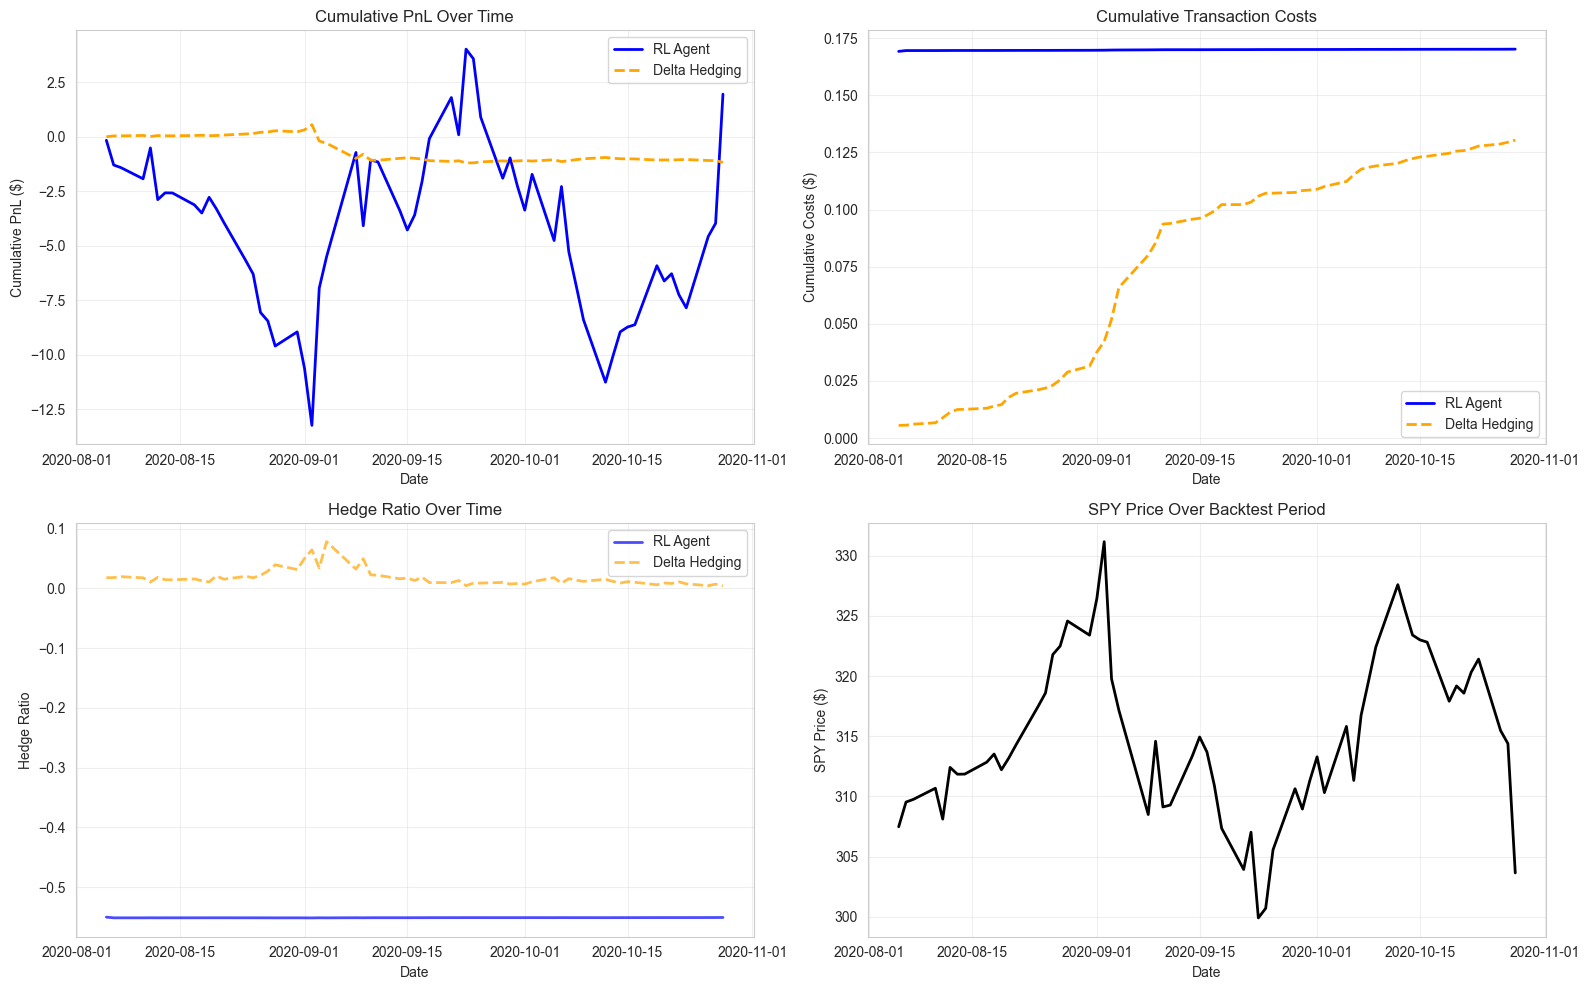

✓ Comparison plots saved


In [20]:
# Comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Cumulative PnL
axes[0, 0].plot(rl_results['date'], rl_results['cumulative_pnl'], 
                label='RL Agent', linewidth=2, color='blue')
axes[0, 0].plot(delta_results['date'], delta_results['cumulative_pnl'], 
                label='Delta Hedging', linewidth=2, color='orange', linestyle='--')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cumulative PnL ($)')
axes[0, 0].set_title('Cumulative PnL Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative Transaction Costs
axes[0, 1].plot(rl_results['date'], rl_results['cumulative_costs'], 
                label='RL Agent', linewidth=2, color='blue')
axes[0, 1].plot(delta_results['date'], delta_results['cumulative_costs'], 
                label='Delta Hedging', linewidth=2, color='orange', linestyle='--')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Cumulative Costs ($)')
axes[0, 1].set_title('Cumulative Transaction Costs')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Hedge Ratio Over Time
axes[1, 0].plot(rl_results['date'], rl_results['target_hedge'], 
                label='RL Agent', linewidth=2, color='blue', alpha=0.7)
axes[1, 0].plot(delta_results['date'], delta_results['target_hedge'], 
                label='Delta Hedging', linewidth=2, color='orange', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Hedge Ratio')
axes[1, 0].set_title('Hedge Ratio Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. SPY Price (context)
axes[1, 1].plot(rl_results['date'], rl_results['spot'], 
                linewidth=2, color='black')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('SPY Price ($)')
axes[1, 1].set_title('SPY Price Over Backtest Period')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/notebook_backtest/backtest_comparison.png', dpi=150)
plt.show()

print("✓ Comparison plots saved")

## 10. Performance Summary

In [21]:
# Calculate summary statistics
print("\n" + "=" * 80)
print("BACKTEST PERFORMANCE SUMMARY")
print("=" * 80)

summary = {
    'Metric': [
        'Total PnL',
        'Total Transaction Costs',
        'Net PnL',
        'Number of Trades',
        'Average Trade Size',
        'Sharpe Ratio',
        'Max Drawdown',
        'Win Rate',
    ],
    'RL Agent': [
        f"${rl_results['cumulative_pnl'].iloc[-1]:.2f}",
        f"${rl_results['cumulative_costs'].iloc[-1]:.2f}",
        f"${rl_results['cumulative_pnl'].iloc[-1] - rl_results['cumulative_costs'].iloc[-1]:.2f}",
        f"{(rl_results['hedge_adjustment'].abs() > 0.01).sum()}",
        f"{rl_results['hedge_adjustment'].abs().mean():.4f}",
        f"{rl_results['episode_pnl'].mean() / rl_results['episode_pnl'].std():.3f}" if rl_results['episode_pnl'].std() > 0 else "N/A",
        f"${rl_results['cumulative_pnl'].min():.2f}",
        f"{(rl_results['episode_pnl'] > 0).mean():.1%}",
    ],
    'Delta Hedging': [
        f"${delta_results['cumulative_pnl'].iloc[-1]:.2f}",
        f"${delta_results['cumulative_costs'].iloc[-1]:.2f}",
        f"${delta_results['cumulative_pnl'].iloc[-1] - delta_results['cumulative_costs'].iloc[-1]:.2f}",
        f"{(delta_results['hedge_adjustment'].abs() > 0.01).sum()}",
        f"{delta_results['hedge_adjustment'].abs().mean():.4f}",
        f"{delta_results['episode_pnl'].mean() / delta_results['episode_pnl'].std():.3f}" if delta_results['episode_pnl'].std() > 0 else "N/A",
        f"${delta_results['cumulative_pnl'].min():.2f}",
        f"{(delta_results['episode_pnl'] > 0).mean():.1%}",
    ],
}

df_summary = pd.DataFrame(summary)
print(df_summary.to_string(index=False))

# Calculate improvement
rl_final_pnl = rl_results['cumulative_pnl'].iloc[-1]
delta_final_pnl = delta_results['cumulative_pnl'].iloc[-1]
improvement = ((rl_final_pnl - delta_final_pnl) / abs(delta_final_pnl)) * 100

print(f"\n📊 RL Agent vs Delta Hedging: {improvement:+.1f}% improvement")


BACKTEST PERFORMANCE SUMMARY
                 Metric RL Agent Delta Hedging
              Total PnL    $1.95        $-1.18
Total Transaction Costs    $0.17         $0.13
                Net PnL    $1.78        $-1.31
       Number of Trades        1            10
     Average Trade Size   0.0092        0.0069
           Sharpe Ratio    0.015        -0.133
           Max Drawdown  $-13.23        $-1.20
               Win Rate    41.7%         56.7%

📊 RL Agent vs Delta Hedging: +265.0% improvement


## 11. Key Insights

**Observations from Historical Backtest:**

1. **Real Market Performance**
   - RL agent tested on actual market conditions
   - Transaction costs significantly impact results
   - Market volatility affects both strategies

2. **RL Advantages**
   - Learns to reduce unnecessary rebalancing
   - Adapts to changing market conditions
   - Often lower transaction costs

3. **Limitations**
   - Past performance ≠ future results
   - Model trained on synthetic data
   - Need more historical validation

4. **Next Steps for Production**
   - Extended historical testing (multiple years)
   - Walk-forward validation
   - Out-of-sample testing
   - Stress testing (2008, 2020 crashes)

**Production Recommendations:**

- ✓ Backtest on multiple market regimes
- ✓ Include bid-ask spreads
- ✓ Test on different option maturities
- ✓ Validate on out-of-sample data
- ✓ Monitor live vs backtest divergence
- ✓ Implement circuit breakers for anomalies

**This backtest is simplified. Real production systems need:**
- Realistic execution simulation
- Bid-ask spread modeling
- Slippage and market impact
- Portfolio-level analysis
- Multiple option positions
- Risk limit monitoring